# Integrantes:

* ### Andresa Bicudo
* ### Gabriel Yamashita
* ### Leonardo Malta

----

# Introdução:
A pandemia do corona vírus fez com que o futebol parasse, inclusive o campeonato inglês (Premiere League). Existem campeonatos que foram interrompidos, como o campeonato francês, mesmo sem ter finalizado todos os jogos e também há campeonatos que retonaram porém com desempenhos diferentes de cada equipe. Isso fez com que surgisse o seguinte questionamento: o que provavelmente ocorreria com o campeonato inglês se a pandemia não tivesse a interrompido?

----

# Objetivo:
Prever o restante do campeonato inglês com base no desempenho e estatísitcas das equipes até a 30ª rodada. 

----

# Imports de Bibliotecas:

In [1]:
# Importanto Bibliotecas para o Trabalho:

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

import scipy as scp
import sklearn

from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

----

# Separação dos Dados:

In [2]:
# Carregando os dados do Excell para o pandas:
dados = pd.read_excel('masterdata.xlsx')
dados.head(2)

,MatchID,Home_team,Away_team,Score_home,Score_away,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,Shots_away,Touches_home,Touches_away,Passes_home,Passes_away,Tackles_home,Tackles_away,Clearances_home,Clearances_away,Corners_home,Corners_away,Offsides_home,Offsides_away,Yellow_cards_home,Yellow_cards_away,Fouls_conceded_home,Fouls_conceded_away,Red_cards_home,Red_cards_away,year,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away
0,5937,Blackburn,Reading,3,3,54.0,46.0,6,4,15,11,553,464,356,287,22,13,33,19,5,10,5,3,2,0,18,7,0,0,2007,18.84,21,19.28,25,10.52,25,0.00,19
1,5938,Bolton,Aston Villa,2,2,47.1,52.9,2,2,11,7,457,493,318,343,24,15,23,20,7,6,0,2,2,1,10,11,0,0,2007,19.38,16,4.39,16,28.16,17,2.08,18


In [3]:
# Separando os resultados dos jogos em uma nova coluna e em números (0, 1 e 2):
# 0 = time da casa
# 1 = empate
# 2 = time de fora

def Determina_Resultado(df, home, away):
    if df[home] > df[away]: # time da casa ganha
        return 0
    elif df[home] < df[away]: # time de fora ganha
        return 2
    elif df[home] == df[away]: # empate
        return 1

In [4]:
# Criando uma coluna com os números que representam os resultados dos jogos:
dados['Result'] = dados.apply(
    lambda dados: Determina_Resultado(dados, 'Score_home', 'Score_away'), axis=1)

dados.head(2)

,MatchID,Home_team,Away_team,Score_home,Score_away,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,Shots_away,Touches_home,Touches_away,Passes_home,Passes_away,Tackles_home,Tackles_away,Clearances_home,Clearances_away,Corners_home,Corners_away,Offsides_home,Offsides_away,Yellow_cards_home,Yellow_cards_away,Fouls_conceded_home,Fouls_conceded_away,Red_cards_home,Red_cards_away,year,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away,Result
0,5937,Blackburn,Reading,3,3,54.0,46.0,6,4,15,11,553,464,356,287,22,13,33,19,5,10,5,3,2,0,18,7,0,0,2007,18.84,21,19.28,25,10.52,25,0.00,19,1
1,5938,Bolton,Aston Villa,2,2,47.1,52.9,2,2,11,7,457,493,318,343,24,15,23,20,7,6,0,2,2,1,10,11,0,0,2007,19.38,16,4.39,16,28.16,17,2.08,18,1


----

# Obtendo Variáveis de Interesse:

In [5]:
# Definindo variáveis importantes: 

# removendo as colunas que não serão necessárias para calcular as probabilidades
stats = dados.drop(columns=[
    'MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away',
    'year', 'Result'])

# definindo as colunas dos nomes dos times
games = dados.loc[: , ['Home_team', 'Away_team']]

# definindo as colunas do resultado (em 0, 1 e 2)
results = dados.loc[: , ['Result']]

stats.head(2)

,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,Shots_away,Touches_home,Touches_away,Passes_home,Passes_away,Tackles_home,Tackles_away,Clearances_home,Clearances_away,Corners_home,Corners_away,Offsides_home,Offsides_away,Yellow_cards_home,Yellow_cards_away,Fouls_conceded_home,Fouls_conceded_away,Red_cards_home,Red_cards_away,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away
0,54.0,46.0,6,4,15,11,553,464,356,287,22,13,33,19,5,10,5,3,2,0,18,7,0,0,18.84,21,19.28,25,10.52,25,0.00,19
1,47.1,52.9,2,2,11,7,457,493,318,343,24,15,23,20,7,6,0,2,2,1,10,11,0,0,19.38,16,4.39,16,28.16,17,2.08,18


## - Heatmap (Teste 1):

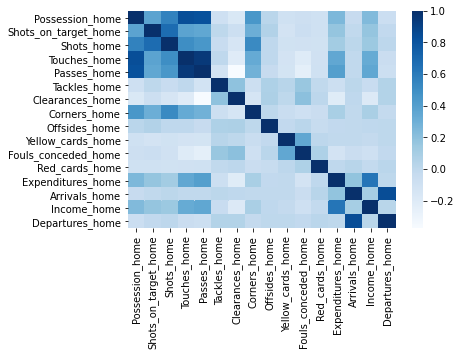

In [6]:
# Obtendo a correlação dos dados para times que jogam em seu estádio:
home_features = [i for i in list(stats) if '_home' in i]
corr = stats[home_features].corr()
sns.heatmap(corr, cmap="Blues")

### Fatores relevantes:
A partir da análise do heatmap, é possível saber se duas variáveis estão medindo características similares. 
Por exemplo, a quantidade de passes ("touches_home") está muito interligada com a posse de bola. 
Para eliminar as variáveis que se relacionam, usa-se o **"Variance Inflation Factor"**, que é um fator que indentifica multicolinearidade de duas variáveis. 
**Valores maiores que 5** significam que há muita correlação. 

Mais informações em: https://www.statisticshowto.com/variance-inflation-factor/.

In [7]:
# Enumera elementos de uma lista para percorrer com o 'for':
enumerate(list(stats))

In [8]:
# Detectando a multicolinearidade entre características a partir do fator de inflação de variância:
# armazenando esses valores numa lista
variance_inflation = []
for i, feature in enumerate(list(stats)):
    vif_tup = (feature, variance_inflation_factor(stats.values, i))
    variance_inflation.append(vif_tup)

    
# sabendo que os fatores maiores de 5 possuem alta multicolineariade
# selecionaremos apenas os que são menores (ou iguais, mas nesse caso não há diferença) que 5
# armazenando os relevantes em uma lista
relevant_features = []
for i in range(len(variance_inflation)):
    if variance_inflation[i][1] <= 5:
        relevant_features.append(variance_inflation[i][0])

print('Número de itens relevantes: {0}\n'.format(len(relevant_features)))
print(relevant_features)

Número de itens relevantes: 10

['Offsides_home', 'Offsides_away', 'Yellow_cards_home', 'Yellow_cards_away', 'Red_cards_home', 'Red_cards_away', 'Expenditures_home', 'Income_home', 'Expenditures_away', 'Income_away']


### Conclusão do Heatmap:

A conclusão que pode ser feita é a de que a "variance inflation" não é um bom parâmetro para determinar variáveis importantes.

----

# Random Forest (Tentativa 1):
(A **Tentativa 1** é referente ao uso de todos os dados)

O Random Forest é um método de Regressão baseado em várias árvores de probabilidade. 
Cada uma delas faz as probabilidades separadamente usando ordens diferentes entre suas variáveis. 
Com isso, caso apresente algum erro, ele será minimizado.
Esse método é uma técnica de "bagging", já que as árvores funcionam paralelamente e não interferem umas nas outras.

In [9]:
# definindo X e Y
# X - dados
# Y - resultados

RF_X1 = stats.values
RF_y1 = results.values

In [10]:
# separando os dados em treino e teste
RF_X_train1, RF_X_test1, RF_y_train1, RF_y_test1 = train_test_split(RF_X1, RF_y1, test_size = .25, random_state = 42)

In [11]:
# aplicando o Random Forest
classificador_RF = RandomForestClassifier(n_estimators=500,random_state=42)
classificador_RF.fit(RF_X_train1, RF_y_train1)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(n_estimators=500, random_state=42)

In [12]:
# Medindo a acurácia do modelo Random Forest
RF_y_pred1 = classificador_RF.predict(RF_X_test1)
print('Acurácia do modelo Random Forest com todas as variáveis:', accuracy_score(RF_y_test1, RF_y_pred1))

Acurácia do modelo Random Forest com todas as variáveis: 0.6145741878841089


# Random Forest (Tentativa 2):
(A **Tentativa 2** é referente ao uso das variáveis "relevantes", nesse caso, do Heatmap)

In [13]:
# definindo X e Y
# X - dados dos features relevantes
# Y - resultados

RF_X2 = (stats.loc[: , relevant_features]).values
RF_y2 = results.values

In [14]:
# separando teste e treino
RF_X_train2, RF_X_test2, RF_y_train2, RF_y_test2 = train_test_split(RF_X2, RF_y2, test_size = .25, random_state = 42)

In [15]:
# aplicando o Random Forest
classificador_RF = RandomForestClassifier(n_estimators=500, random_state=42)
classificador_RF.fit(RF_X_train2, RF_y_train2)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(n_estimators=500, random_state=42)

In [16]:
# Medindo a acurácia do modelo Random Forest com as novas variáveis consideradas relevantes
RF_y_pred2 = classificador_RF.predict(RF_X_test2)
print('Acurácia do modelo Random Forest com a relevant features: ', accuracy_score(RF_y_test2, RF_y_pred2))

Acurácia do modelo Random Forest com a relevant features:  0.52414398595259


## Nova seleção de variáveis (Teste 2):

In [17]:
# encontrando a ordem de importância das variáveis, de acordo com o Random Forest

# calculando um novo Random Forest
forest = RandomForestClassifier(n_estimators=500,random_state=42)
forest.fit(RF_X_train2, RF_y_train2)

# organizando as variáveis
features = stats.columns
importances = forest.feature_importances_

# imprimindo a tabela
indices = np.argsort(importances)[::-1]
indices

for f in range(RF_X_train2.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,features[indices[f]], importances[indices[f]]))

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


 1) Touches_home                   0.172265
 2) Passes_home                    0.165900
 3) Passes_away                    0.158659
 4) Touches_away                   0.154282
 5) Possession_away                0.088736
 6) Possession_home                0.083353
 7) Shots_on_target_away           0.078670
 8) Shots_on_target_home           0.068798
 9) Shots_away                     0.015023
10) Shots_home                     0.014314


In [18]:
# Após testarmos as quantidades, utilizaremos as 23 primeiras vairiáveis da lista acima, que é a melhor opção
# porque obtém-se o melhor resultado

relevant_features = []
for i in range(len(features[indices])):
    if i <= 22:
        relevant_features.append(features[indices][i])
    else:
        pass
print(relevant_features)

['Touches_home', 'Passes_home', 'Passes_away', 'Touches_away', 'Possession_away', 'Possession_home', 'Shots_on_target_away', 'Shots_on_target_home', 'Shots_away', 'Shots_home']


----

# Regressão Multinominal (Tentativa 1):
(A **Tentativa 1** se refere ao uso de todos os dados)

A Regressão Multinomial é usada para relacionar uma variável nominal dependente (nesse caso, resultado de um jogo) e outras variáveis independentes (número de passes, time adversário, estádio).

In [19]:
# aplicando o método de Regressão Multinomial (RM)
# Y, endog é a variável endógena (de dentro) e o X, exog é a exógena (de fora)
# tirando os resultados (y) de uma organização em forma de tabela e tornando-o uma lista com o .flatten()

logit_model = sm.MNLogit(endog=y_train1.flatten(), exog=X_train1)
result = logit_model.fit()

# criando tabelas que explicitam os dados comparados e permitem a análise dos resultados
stats1 = result.summary()
stats2 = result.summary2()

print(stats1)

NameError: name 'y_train1' is not defined

In [20]:
print(stats2)

NameError: name 'stats2' is not defined

In [21]:
#
def Determina_Acuracia_Multinominal(predict, teste_y):
    lista_maiores = [max(i) for i in predict]
    lista_index = []
    for i in range(len(predict)):
        for p in range(3):
            if predict[i][p] == lista_maiores[i]:
                lista_index.append(p)

    flat_list_of_results = []
    for sublist in np.ndarray.tolist(teste_y):  #y_test
        for item in sublist:
            flat_list_of_results.append(item)

    comparativo_rm = pd.DataFrame({
        'Resultado': flat_list_of_results,
        'Modelo': lista_index
    })

    corretos = 0
    for i in range(len(comparativo_rm['Resultado'])):
        if comparativo_rm['Resultado'][i] == comparativo_rm['Modelo'][i]:
            corretos += 1

    accuracy = corretos / (len(comparativo_rm['Resultado']))

    print(
        'A acurácia desse modelo de Regressão Multinominal é: {}'
        .format(accuracy))

In [22]:
# determinando a acurácia do modelo Regressão Multinominal
r1_rm = result.predict(exog=X_test1)
Determina_Acuracia_Multinominal(r1_rm, y_test1)

NameError: name 'result' is not defined

# Regressão Multinominal (Tentativa 2):
(A **Tentativa 2** se refere ao uso dos "Fatores Relevantes")

Por meio dos valores de "p", conclui-se que  serão eliminadas as variáveis que são maiores que 0.1 em pelo menos duas das listas do summary, ou seja: (x6, x7, x15, x18, x20, x21, x22, x26, x27, x28, x30, x31 e x32).

In [23]:
# o índice das variáveis que tem p > 0.1 são os descritos acima
# para obtermos os índices correspondentes na lista de dados, fazemos estes - 1

index_inrrelevant = [5, 6, 14, 17, 19, 20, 21, 25, 26, 27, 29, 30, 31]
new_relevant_features = list(stats.drop(stats.columns[index_inrrelevant], axis = 1).columns)

# X - dados de features relevantes
# Y - resultados
X2 = (stats.loc[: , new_relevant_features]).values
y2 = results.values

# separando teste e treino
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = .2, random_state = 42)

# aplicando a Regressão Multinominal
logit_model2 = sm.MNLogit(endog=y_train2.flatten(), exog=X_train2)
result2 = logit_model2.fit()

# obtendo os dados desse teste
stats1_2 = result2.summary()
stats2_2= result2.summary2()

print(stats1_2)

Optimization terminated successfully.
         Current function value: 0.784299
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 3644
Model:                        MNLogit   Df Residuals:                     3606
Method:                           MLE   Df Model:                           36
Date:                Mon, 08 Jun 2020   Pseudo R-squ.:                  0.2618
Time:                        05:42:33   Log-Likelihood:                -2858.0
converged:                       True   LL-Null:                       -3871.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1358      0.018      7.468      0.000       0.100       0.171
x2            -0.1480      0.

In [24]:
print(stats2_2)

                        Results: MNLogit
Model:              MNLogit          Pseudo R-squared: 0.262    
Dependent Variable: y                AIC:              5791.9686
Date:               2020-06-08 05:42 BIC:              6027.6004
No. Observations:   3644             Log-Likelihood:   -2858.0  
Df Model:           36               LL-Null:          -3871.7  
Df Residuals:       3606             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
--------------------------------------------------------------
 y = 0    Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------
 x1       0.1358    0.0182    7.4680  0.0000   0.1002   0.1715
 x2      -0.1480    0.0197   -7.5077  0.0000  -0.1866  -0.1094
 x3      -0.3739    0.0271  -13.7868  0.0000  -0.4271  -0.3208
 x4       0.1748    0.0250    6.9868  0.0000   0.1257   0.223

In [25]:
# Predição 2 - Regressão Multinominal (Retirada de algumas variáveis)
r1_rm2 = result2.predict(exog=X_test2)
Determina_Acuracia_Multinominal(r1_rm2, y_test2)

A acurácia desse modelo de Regressão Multinominal é: 0.6271929824561403


# Regressão Multinominal (Tentativa 3):

Observando novamente os valores de p, ainda é possível elininar mais variáveis, como x6, x9 e x10.

In [26]:
# índice da tabela - 1 = índice da lista
index_inrrelevant3 = [5, 8, 9]
for i in range(len(index_inrrelevant3)):
    new_relevant_features.pop(index_inrrelevant3[i])

# X - dados das variáveis consideradas relevantes
# Y - resultados
X3 = (stats.loc[: , new_relevant_features]).values
y3 = results.values

# separando teste e treino
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = .2, random_state = 43)

# aplicando o modelo de Regressão Multinominal
logit_model3 = sm.MNLogit(endog=y_train3.flatten(), exog=X_train3)
result3 = logit_model3.fit()

# obtendo os dados desse teste
stats1_3 = result3.summary()
stats2_3= result3.summary()

print(stats1_3)

Optimization terminated successfully.
         Current function value: 0.820474
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 3644
Model:                        MNLogit   Df Residuals:                     3612
Method:                           MLE   Df Model:                           30
Date:                Mon, 08 Jun 2020   Pseudo R-squ.:                  0.2277
Time:                        05:42:34   Log-Likelihood:                -2989.8
converged:                       True   LL-Null:                       -3871.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1712      0.018      9.668      0.000       0.136       0.206
x2            -0.1394      0.

In [27]:
print(stats2_3)

                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 3644
Model:                        MNLogit   Df Residuals:                     3612
Method:                           MLE   Df Model:                           30
Date:                Mon, 08 Jun 2020   Pseudo R-squ.:                  0.2277
Time:                        05:42:34   Log-Likelihood:                -2989.8
converged:                       True   LL-Null:                       -3871.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1712      0.018      9.668      0.000       0.136       0.206
x2            -0.1394      0.019     -7.223      0.000      -0.177      -0.102
x3            -0.3953      0.026    -15.014      0.0

In [28]:
# Predição 3 - Regressão Multinominal (Retirada de algumas variáveis)
r1_rm3 = result3.predict(exog=X_test3)
Determina_Acuracia_Multinominal(r1_rm3, y_test3)

A acurácia desse modelo de Regressão Multinominal é: 0.6173245614035088


O modelo obteve menos acertos ao passo que as variáveis com valor p maior que 0.1 foram retiradas. Assim, usa-se outro métodos para identificar melhor modelo e quantidade de variáveis que melhor descrevem o modelo.

----

# Nova Seleção de Melhores Variáveis

In [29]:
# aplicando o Random Forest
forest = RandomForestClassifier(n_estimators=500,random_state=42)
forest.fit(X_train1, y_train1)

# definindo as variáveis relevantes
features = stats.columns
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
indices
for f in range(X_train1.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,features[indices[f]], importances[indices[f]]))

NameError: name 'X_train1' is not defined

In [30]:
# Por tentativa e erro, utilizando-se as  23 primeiras vairiáveis da lista acima
# obtem-se o melhor resultado
relevant_features = []
for i in range(len(features[indices])):
    if i <= 22:
        relevant_features.append(features[indices][i])
    else:
        pass
relevant_features

['Touches_home',
 'Passes_home',
 'Passes_away',
 'Touches_away',
 'Possession_away',
 'Possession_home',
 'Shots_on_target_away',
 'Shots_on_target_home',
 'Shots_away',
 'Shots_home']

# Random Forest (Tentativa 3):

In [31]:
# Predição com as novas variáveis relevantes
# X - dados das variáveis consideradas relevantes
# Y - resultados
RF_X3 = (stats.loc[: , relevant_features]).values
RF_y3 = results.values

In [32]:
# separando treino e teste
RF_X_train3, RF_X_test3, RF_y_train3, RF_y_test3 = train_test_split(RF_X3, RF_y3, test_size = .25, random_state = 42)

In [33]:
# aplicando o Random Forest
classificador_RF = RandomForestClassifier(n_estimators=500, random_state=42)
classificador_RF.fit(RF_X_train3, RF_y_train3)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(n_estimators=500, random_state=42)

In [34]:
# medindo a acurácia desse modelo
RF_y_pred3 = classificador_RF.predict(RF_X_test3)
print('Acurácia do modelo Random Forest com as novas relevant features: ', accuracy_score(RF_y_test3, RF_y_pred3))

Acurácia do modelo Random Forest com as novas relevant features:  0.5539947322212467


----
# Regressão Multinominal (Tentativa 4):

In [35]:
# aplicando a Regressão Multinominal
logit_model = sm.MNLogit(endog=y_train.flatten(), exog=X_train)
result = logit_model.fit()
r4_rm = result.predict(exog=X_test)
Determina_Acuracia_Multinominal(r4_rm, y_test)

NameError: name 'y_train' is not defined

Até o momento, a regressão Multinominal 4 está obtendo a mehor acurácia.

----

# Regressão Naive Bayes Multinomial (Tentativa 1):
(usando todos os dados)

In [37]:
# X - todos os dados
# Y - resultados
NB_X1 = stats.values
NB_y1 = results.values

In [38]:
# separa treino e teste
NB_X_train1, NB_X_test1, NB_y_train1, NB_y_test1 = train_test_split(NB_X1, NB_y1, test_size = .25, random_state = 42)

In [39]:
# aplicando Naive Bayes Multinominal
classificador_NB_multinomial = MultinomialNB()
classificador_NB_multinomial.fit(NB_X_train1, NB_y_train1)

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MultinomialNB()

In [40]:
# medindo a acurácia desse modelo
NB_y_pred1 = classificador_NB_multinomial.predict(NB_X_test1)
print('Acurácia do modelo Naive Bayes Multinomial usando todos os dados:', accuracy_score(NB_y_test1, NB_y_pred1))

Acurácia do modelo Naive Bayes Multinomial usando todos os dados: 0.4793678665496049


----

# Regressão Naive Bayes Multinomial (Tentativa 2):
((usando as Relevant Features)

In [41]:
# X - todos os dados
# Y - resultados
NB_X2 = (stats.loc[: , relevant_features]).values
NB_y2 = results.values

In [42]:
# separa treino e teste
NB_X_train2, NB_X_test2, NB_y_train2, NB_y_test2 = train_test_split(NB_X2, NB_y2, test_size = .25, random_state = 42)

In [43]:
classificador_NB_multinomial = MultinomialNB()
classificador_NB_multinomial.fit(NB_X_train2, NB_y_train2)

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MultinomialNB()

In [44]:
# medindo a acurácia desse modelo
NB_y_pred2 = classificador_NB_multinomial.predict(NB_X_test2)
print('Acurácia do modelo Naive Bayes Multinomial usando as relevant features:', accuracy_score(NB_y_test2, NB_y_pred2))

Acurácia do modelo Naive Bayes Multinomial usando as relevant features: 0.4363476733977173


----

# K Neighbors Classifier (Tentativa 1):
(usando todos os dados)

In [45]:
KN_X1 = stats.values
KN_y1 = results.values

In [46]:
# separa treino e teste
KN_X_train1, KN_X_test1, KN_y_train1, KN_y_test1 = train_test_split(KN_X1, KN_y1, test_size = .25, random_state = 42)

In [47]:
classificador_KNeigh = KNeighborsClassifier(n_neighbors=26)
classificador_KNeigh.fit(KN_X_train1, KN_y_train1)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(n_neighbors=26)

In [48]:
# medindo a acurácia desse modelo
KN_y_pred1 = classificador_KNeigh.predict(KN_X_test1)
print('Acurácia do modelo K Neighbors usando todos os dados: ', accuracy_score(KN_y_test1, KN_y_pred1))

Acurácia do modelo K Neighbors usando todos os dados:  0.5039508340649693


# K Neighbors Classifier (Tentativa 2):
(usando as Relevant Features)

In [49]:
KN_X2 = (stats.loc[: , relevant_features]).values
KN_y2 = results.values

In [50]:
# separa treino e teste
KN_X_train2, KN_X_test2, KN_y_train2, KN_y_test2 = train_test_split(KN_X2, KN_y2, test_size = .25, random_state = 42)

In [51]:
classificador_KNeigh = KNeighborsClassifier(n_neighbors=25)
classificador_KNeigh.fit(KN_X_train2, KN_y_train2)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(n_neighbors=25)

In [52]:
# medindo a acurácia desse modelo
KN_y_pred2 = classificador_KNeigh.predict(KN_X_test2)
print('Acurácia do modelo K Neighbors usando os relevants features:', accuracy_score(KN_y_test2, KN_y_pred2))

Acurácia do modelo K Neighbors usando os relevants features: 0.45829675153643545


----

# Gradient Boosting Classificador (Tentativa 1):
(usando todos os dados)

In [53]:
GB_X1 = stats.values
GB_y1 = results.values

In [54]:
# separa treino e teste
GB_X_train1, GB_X_test1, GB_y_train1, GB_y_test1 = train_test_split(GB_X1, GB_y1, test_size = .25, random_state=0)

In [55]:
classificador_Gradiente = GradientBoostingClassifier(random_state=0)
classificador_Gradiente.fit(GB_X_train1, GB_y_train1)

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingClassifier(random_state=0)

In [56]:
# medindo a acurácia desse modelo
GB_y_pred1 = classificador_Gradiente.predict(GB_X_test1)
print('Acurácia do modelo Gradient Boosting usando todos os dados: ', accuracy_score(GB_y_test1, GB_y_pred1))

Acurácia do modelo Gradient Boosting usando todos os dados:  0.6488147497805092


# Gradient Boosting Classificador (Tentativa 2):
(usando as relevant features)

In [57]:
GB_X2 = (stats.loc[: , relevant_features]).values
GB_y2 = results.values

In [58]:
# separa treino e teste
GB_X_train2, GB_X_test2, GB_y_train2, GB_y_test2 = train_test_split(GB_X2, GB_y2, test_size = .25, random_state=0)

In [59]:
classificador_Gradiente = GradientBoostingClassifier(random_state=0)
classificador_Gradiente.fit(GB_X_train2, GB_y_train2)

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingClassifier(random_state=0)

In [60]:
# medindo a acurácia desse modelo
GB_y_pred2 = classificador_Gradiente.predict(GB_X_test2)
print('Acurácia do modelo Gradient Boosting usando as relevant features: ', accuracy_score(GB_y_test2, GB_y_pred2))

Acurácia do modelo Gradient Boosting usando as relevant features:  0.5987708516242318


----

# Fazendo Predições com o Modelo

In [61]:
def Historico_Confrontos(df, home, away, result_model):
    matches = df.loc[(df['Home_team'] == home) & (df['Away_team'] == away), :]
    resumo = matches.loc[:, relevant_features].mean().to_frame().T
    resultado = result_model.predict(exog=resumo)
    return resultado


Historico_Confrontos(dados, 'Everton', 'Liverpool', result)

NameError: name 'result' is not defined